In [153]:
import sys
import pg8000  
import os
import pathlib2
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import stats
import math
import seaborn as sns
%matplotlib inline
import postpatch_funcs as pf
import warnings
warnings.filterwarnings('ignore')
#print(sys.path)

In [154]:
#code from Agata
#these are nice functions to open LIMS, make a query and then close LIMS after

def _connect(user="limsreader", host="limsdb2", database="lims2", password="limsro", port=5432):
    conn = pg8000.connect(user=user, host=host, database=database, password=password, port=port)
    return conn, conn.cursor()

def _select(cursor, query):
    cursor.execute(query)
    columns = [ d[0] for d in cursor.description ]
    return [ dict(zip(columns, c)) for c in cursor.fetchall() ]

def limsquery(query, user="limsreader", host="limsdb2", database="lims2", password="limsro", port=5432):
    """A function that takes a string containing a SQL query, connects to the LIMS database and outputs the result."""
    conn, cursor = _connect(user, host, database, password, port)
    try:
        results = _select(cursor, query)
    finally:
        
        #THESE ARE IMPORTANT!!!!!!
        #Every query needs to be closed when done
        cursor.close()             
        conn.close()
    return results


#this last function will take our query results and put them in a dataframe so that they are easy to work with
def get_lims_dataframe(query):
    '''Return a dataframe with lims query'''
    result = limsquery(query)
    try:
        data_df = pd.DataFrame(data=result, columns=result[0].keys())
    except IndexError:
        print "Could not find results for your query."
        data_df = pd.DataFrame()
    return data_df

In [586]:
home = pathlib2.Path.home()
full_path = home/"documents"/"stash"/"ps-metadata-analysis"/"data"/"patch_seq_log_mouse.csv"
full_path = str(full_path)
full_path
initial = pd.read_csv(full_path)

In [587]:
ps = initial[['Date', 'cell type', 'File', 'Post patch?', 'Post patch pipette R' , 'PCR cycles', 'SM_QC_PF', 'Bad dates']]
ps["File"].str.strip()

ps['Bad dates'] = ps['Bad dates'].astype('category')
ps['PCR cycles'] = ps['PCR cycles'].astype('category')
ps['cell type'] = ps['cell type'].astype('category')
ps['Post patch?'] = ps['Post patch?'].astype('category')
ps = ps[ps['PCR cycles'] == 21]
ps = ps[ps['Bad dates'] != 'x']
ps = ps[ps['SM_QC_PF'] != 'cnt']
ps = ps[(ps['cell type'] == 'tdt+') | (ps['cell type'] == 'Cre+')]
ps.dropna(subset = ['Post patch?'], inplace = True)
ps.tail()

,Date,cell type,File,Post patch?,Post patch pipette R,PCR cycles,SM_QC_PF,Bad dates
5371,180214,Cre+,Cux2-CreERT2;Ai14-375870.07.01.01,nucleus_present,1500.0,21.0,NaN,NaN
5380,180214,Cre+,Cux2-CreERT2;Ai14-375871.06.01.01,nucleus_absent,300.0,21.0,NaN,NaN
5393,180216,Cre+,Cux2-CreERT2;Ai14-375864.06.02.01,nucleus_present,1500.0,21.0,NaN,NaN
5394,180216,Cre+,Cux2-CreERT2;Ai14-375864.06.02.02,nucleus_present,1000.0,21.0,NaN,NaN
5395,180216,Cre+,Cux2-CreERT2;Ai14-375864.06.02.03,nucleus_present,2000.0,21.0,NaN,NaN


In [588]:
ps = pf.postpatch_reclass(ps)
ps['post patch class'] = ps['post patch class'].astype('category', categories=['Nucleated', 'Partial nucleated', 'Outside out', 'No seal', 'Entire cell'])

In [589]:
lims_query = "SELECT cell.name as cell_name, donors.full_genotype \
FROM specimens cell JOIN donors ON cell.donor_id = donors.id \
WHERE cell.ephys_roi_result_id IS NOT NULL"

lims_df = get_lims_dataframe(lims_query)
lims_df.tail()

,full_genotype,cell_name
13904,Slc17a6-IRES-Cre/wt;Ai14(RCL-tdT)/wt,Slc17a6-IRES-Cre;Ai14-376996.04.01.01
13905,Slc17a6-IRES-Cre/wt;Ai14(RCL-tdT)/wt,Slc17a6-IRES-Cre;Ai14-376996.04.02.02
13906,Ndnf-IRES2-dgCre/wt;Ai14(RCL-tdT)/wt,Ndnf-IRES2-dgCre;Ai14-378475.04.02.01
13907,Sst-IRES-FlpO/wt;Ai65F/wt;Ai140(TIT2L-GFP-ICL-...,Ntsr1-Cre_GN220;Ai140;Sst-IRES-FlpO-377972-Ai6...
13908,Sst-IRES-FlpO/wt;Ai65F/wt;Ai140(TIT2L-GFP-ICL-...,Ntsr1-Cre_GN220;Ai140;Sst-IRES-FlpO-377972-Ai6...


In [590]:
ps = pd.merge(left = ps, right = lims_df, left_on = 'File', right_on = 'cell_name', how = 'left')
ps

,Date,cell type,File,Post patch?,Post patch pipette R,PCR cycles,SM_QC_PF,Bad dates,post patch class,full_genotype,cell_name
0,170421,tdt+,Gad2-IRES-Cre;Ai14-313294.04.01.03,Nucleated,NaN,21.0,pass,NaN,Nucleated,Gad2-IRES-Cre/wt;Ai14(RCL-tdT)/wt,Gad2-IRES-Cre;Ai14-313294.04.01.03
1,170421,tdt+,Gad2-IRES-Cre;Ai14-313294.03.02.01,Nucleated,NaN,21.0,pass,NaN,Nucleated,Gad2-IRES-Cre/wt;Ai14(RCL-tdT)/wt,Gad2-IRES-Cre;Ai14-313294.03.02.01
2,170421,tdt+,Gad2-IRES-Cre;Ai14-313294.03.02.02,Nucleated,NaN,21.0,pass,NaN,Nucleated,Gad2-IRES-Cre/wt;Ai14(RCL-tdT)/wt,Gad2-IRES-Cre;Ai14-313294.03.02.02
3,170421,tdt+,Gad2-IRES-Cre;Ai14-313294.05.01.03,Nucleated,NaN,21.0,pass,NaN,Nucleated,Gad2-IRES-Cre/wt;Ai14(RCL-tdT)/wt,Gad2-IRES-Cre;Ai14-313294.05.01.03
4,170424,tdt+,Scnn1a-Tg3-Cre;Ai14-315865.04.01.04,Nucleated,NaN,21.0,pass,NaN,Nucleated,Scnn1a-Tg3-Cre/wt;Ai14(RCL-tdT)/wt,Scnn1a-Tg3-Cre;Ai14-315865.04.01.04
5,170424,tdt+,Rorb-IRES2-Cre;Ai14-315898.03.01.05,Nucleated,NaN,21.0,pass,NaN,Nucleated,Rorb-IRES2-Cre/wt;Ai14(RCL-tdT)/wt,Rorb-IRES2-Cre;Ai14-315898.03.01.05
6,170424,tdt+,Scnn1a-Tg3-Cre;Ai14-315865.04.02.05,Nucleated,NaN,21.0,pass,NaN,Nucleated,Scnn1a-Tg3-Cre/wt;Ai14(RCL-tdT)/wt,Scnn1a-Tg3-Cre;Ai14-315865.04.02.05
7,170424,tdt+,Rorb-IRES2-Cre;Ai14-315898.04.02.05,Nucleated,NaN,21.0,pass,NaN,Nucleated,Rorb-IRES2-Cre/wt;Ai14(RCL-tdT)/wt,Rorb-IRES2-Cre;Ai14-315898.04.02.05
8,170425,tdt+,Rorb-IRES2-Cre;Ai14-315897.04.01.04,Nucleated,NaN,21.0,pass,NaN,Nucleated,Rorb-IRES2-Cre/wt;Ai14(RCL-tdT)/wt,Rorb-IRES2-Cre;Ai14-315897.04.01.04
9,170425,tdt+,Rorb-IRES2-Cre;Ai14-315897.04.02.03,Nucleated,NaN,21.0,pass,NaN,Nucleated,Rorb-IRES2-Cre/wt;Ai14(RCL-tdT)/wt,Rorb-IRES2-Cre;Ai14-315897.04.02.03


In [536]:
ps = ps.drop('Date', 1)
ps = ps.drop('Bad dates', 1)
ps = ps.drop('SM_QC_PF', 1)
ps = ps.drop('PCR cycles', 1)
ps = ps.drop('cell type', 1)
ps = ps.drop('File', 1)
ps = ps.drop('cell_name', 1)
ps = ps.drop('Post patch pipette R', 1)

In [537]:
ps.tail()

,Post patch?,post patch class,full_genotype
2640,entire_cell,Entire cell,Sst-IRES-Cre/wt;Ai14(RCL-tdT)/wt
2641,entire_cell,Entire cell,Htr3a-Cre_NO152/wt;Ai14(RCL-tdT)/wt
2642,entire_cell,Entire cell,Vip-IRES-Cre/wt;Ai14(RCL-tdT)/wt
2643,entire_cell,Entire cell,Vip-IRES-Cre/wt;Ai14(RCL-tdT)/wt
2644,entire_cell,Entire cell,Oxtr-T2A-Cre/wt;Ai14(RCL-tdT)/wt


In [538]:
#ps.head()
ps.dropna(subset = ['full_genotype'], inplace = True)

In [539]:
ps['full_genotype'].value_counts()

Vip-IRES-Cre/wt;Ai14(RCL-tdT)/wt                                283
Slc32a1-IRES-Cre/wt;Ai14(RCL-tdT)/wt                            251
Gad2-IRES-Cre/wt;Ai14(RCL-tdT)/wt                               198
Rbp4-Cre_KL100/wt;Ai14(RCL-tdT)/wt                              195
Sst-IRES-Cre/wt;Ai14(RCL-tdT)/wt                                163
Rorb-IRES2-Cre/wt;Ai14(RCL-tdT)/wt                              154
Pvalb-IRES-Cre/wt;Ai14(RCL-tdT)/wt                              150
Chrna2-Cre_OE25/wt;Ai14(RCL-tdT)/wt                             145
Oxtr-T2A-Cre/wt;Ai14(RCL-tdT)/wt                                113
Ndnf-IRES2-dgCre/wt;Ai14(RCL-tdT)/wt                             87
Htr3a-Cre_NO152/wt;Ai14(RCL-tdT)/wt                              67
Scnn1a-Tg3-Cre/wt;Ai14(RCL-tdT)/wt                               62
Chat-IRES-Cre-neo/wt;Ai14(RCL-tdT)/wt                            60
Nr5a1-Cre/wt;Ai14(RCL-tdT)/wt                                    56
Vipr2-IRES2-Cre/wt;Slc32a1-T2A-FlpO/wt;Ai65(RCFL

In [540]:
types = {'Calb1-IRES2-Cre/wt;Sst-IRES-FlpO/wt;Ai65(RCFL-tdT)/wt': 'unknown',
       'Chat-IRES-Cre-neo/wt;Ai14(RCL-tdT)/wt': 'inhibitory', 
       'Chrna2-Cre_OE25/wt;Ai14(RCL-tdT)/wt': 'inhibitory',
       'Crh-IRES-Cre_ZJH/wt;Sst-IRES-FlpO/wt;Ai65(RCFL-tdT)/wt': 'inhibitory',
       'Ctgf-T2A-dgCre/wt;Ai14(RCL-tdT)/wt': 'excitatory', 
       'Cux2-CreERT2/wt;Ai14(RCL-tdT)/wt': 'excitatory',
       'Gad2-IRES-Cre/wt;Ai14(RCL-tdT)/wt': 'inhibitory',
       'Glt25d2-Cre_NF107/wt;Ai14(RCL-tdT)/wt': 'excitatory',
       'Htr3a-Cre_NO152/wt;Ai14(RCL-tdT)/wt': 'inhibitory',
       'Htr3a-Cre_NO152/wt;Pvalb-T2A-Dre/wt;Ai66(RCRL-tdT)/wt': 'inhibitory',
       'Ndnf-IRES2-dgCre/wt;Ai14(RCL-tdT)/wt': 'inhibitory',
       'Ndnf-IRES2-dgCre/wt;Slc32a1-IRES2-FlpO/wt;Ai65(RCFL-tdT)/wt': 'inhibitory',
       'Nkx2-1-CreERT2/wt;Ai14(RCL-tdT)/wt': 'inhibitory',
       'Nos1-CreERT2/wt;Ai14(RCL-tdT)/wt': 'inhibitory',
       'Nos1-CreERT2/wt;Sst-IRES-FlpO/wt;Ai65(RCFL-tdT)/wt': 'inhibitory',
       'Nr5a1-Cre/wt;Ai14(RCL-tdT)/wt': 'excitatory',
       'Ntsr1-Cre_GN220/wt;Ai14(RCL-tdT)/wt': 'excitatory',
       'Oxtr-T2A-Cre/wt;Ai14(RCL-tdT)/wt': 'mix',
       'Oxtr-T2A-Cre/wt;Pvalb-T2A-FlpO/wt;Ai65(RCFL-tdT)/wt': 'mix',
       'Pdyn-T2A-CreERT2/wt;Ai14(RCL-tdT)/wt': 'unknown',
       'Pvalb-IRES-Cre/wt;Ai14(RCL-tdT)/wt': 'inhibitory',
       'Rbp4-Cre_KL100/wt;Ai14(RCL-tdT)/wt': 'excitatory',
       'Rorb-IRES2-Cre/wt;Ai14(RCL-tdT)/wt': 'excitatory',
       'Rorb-IRES2-Cre-neo/wt;Ai14(RCL-tdT)/wt': 'excitatory',
       'Scnn1a-Tg2-Cre/wt;Ai14(RCL-tdT)/wt': 'excitatory',
       'Scnn1a-Tg3-Cre/wt;Ai14(RCL-tdT)/wt': 'excitatory',
       'Sim1-Cre_KJ18/wt;Ai14(RCL-tdT)/wt': 'excitatory',
       'Slc17a8-IRES2-Cre/wt;Ai14(RCL-tdT)/wt': 'excitatory',
       'Slc17a8-IRES2-Cre/wt;Slc32a1-IRES2-FlpO/wt;Ai65(RCFL-tdT)/wt': 'mix',
       'Slc17a8-iCre/wt;Ai14(RCL-tdT)/wt': 'excitatory',
       'Slc32a1-IRES-Cre/wt;Ai14(RCL-tdT)/wt': 'inhibitory',
       'Slc32a1-IRES2-FlpO/wt;Ai65F/wt': 'inhibitory',
       'Sst-IRES-Cre/wt;Ai14(RCL-tdT)/wt': 'inhibitory',
       'Tac1-IRES2-Cre/wt;Sst-IRES-FlpO/wt;Ai65(RCFL-tdT)/wt': 'unknown',
       'Th-Cre_FI172/wt;Ai14(RCL-tdT)/wt': 'unknown',
       'Tlx3-Cre_PL56/wt;Ai14(RCL-tdT)/wt': 'unknown',
       'Vip-IRES-Cre/wt;Ai14(RCL-tdT)/wt': 'inhibitory',
       'Vipr2-IRES2-Cre/wt;Ai14(RCL-tdT)/wt': 'inhibitory',
       'Vipr2-IRES2-Cre-neo/wt;Ai14(RCL-tdT)/wt': 'inhibitory',
       'Vipr2-IRES2-Cre/wt;Pvalb-T2A-FlpO/wt;Ai65(RCFL-tdT)/wt': 'inhibitory',
       'Vipr2-IRES2-Cre/wt;Slc32a1-T2A-FlpO/wt;Ai65(RCFL-tdT)/wt': 'inhibitory'}

#unknowns: Tac1, Tlx3, Pdyn, Th, Calb1

ps['type'] = ps['full_genotype'].map(types)

In [541]:
ps.tail()

,Post patch?,post patch class,full_genotype,type
2640,entire_cell,Entire cell,Sst-IRES-Cre/wt;Ai14(RCL-tdT)/wt,inhibitory
2641,entire_cell,Entire cell,Htr3a-Cre_NO152/wt;Ai14(RCL-tdT)/wt,inhibitory
2642,entire_cell,Entire cell,Vip-IRES-Cre/wt;Ai14(RCL-tdT)/wt,inhibitory
2643,entire_cell,Entire cell,Vip-IRES-Cre/wt;Ai14(RCL-tdT)/wt,inhibitory
2644,entire_cell,Entire cell,Oxtr-T2A-Cre/wt;Ai14(RCL-tdT)/wt,mix


In [584]:
post_patch = list(ps["post patch class"].unique())
#type(post_patch)
#post_patch
cell_type = list(ps["type"].unique())
#cell_type
genotypes = list(ps["full_genotype"].unique())
x = np.arange(len(genotypes))
#genotypes
bottom = np.zeros(len(genotypes))
y = np.zeros(len(genotypes))
for pp in post_patch:
    #bottom = bottom + y
    #y = [len(ps[(ps['full_genotype'] == f) & (ps['post patch class'] == pp)]) for f in genotypes]
    #plt.bar(x, y, bottom = bottom, label = pp)
    for ct in cell_type:
        w = [len(ps[(ps['full_genotype'] == f) & (ps['post patch class'] == pp) & (ps['type'] == ct)]) for f in genotypes]
        z = [len(ps[(ps['full_genotype'] ==f) & (ps['type'] == ct)]) for f in genotypes]
        w_array = np.array(w)
        z_array = np.array(z)
        print w_array
        #print z_array
        #y = [np.float64(a) / np.float64(b) for a,b in zip(w,z)]
        #print y
        #plt.bar(x, y, bottom = bottom, label = (pp, ct))
#plt.legend()        

[ 91   0   0   0   0   0  61   0 136 140  77   7  94   0   0   0   1  19
   0  37  26  38  19   0   0   0   0   0   0   0  13   0  15   0   3   7
   5   3   0   0]
[  0  22  43  22  14  20   0  30   0   0   0   0   0   9 119   6   0   0
  11   0   0   0   0   0  13   0   0   0   2  16   0   0   0   0   0   0
   0   0   0   0]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 59  0
  0 19  0  0  0  0  6  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 15  0  5  0  0  0  0  0  7  0  0  0  0  4  0]
[24  0  0  0  0  0 28  0 33 31 13  0 18  0  0  0  0 15  0 11 11  9  3  0  0
  0  0  0  0  0  2  0  2  0  3  0  1  1  0  0]
[ 0  3 20 13  3 12  0  3  0  0  0  0  0  2 17  0  0  0  4  0  0  0  0  0  4
  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 14  0
  0  3  0  0  0  0  3  0  0  0  0  0  0  0  0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 0 2 

In [466]:
ps1 = ps.groupby(['type', 'full_genotype', 'post patch class']).agg(['count'])

In [468]:
ps1

Post patch?
                                                                                      count
type       full_genotype                                      post patch class             
excitatory Ctgf-T2A-dgCre/wt;Ai14(RCL-tdT)/wt                 Nucleated                  11
                                                              Partial nucleated           4
                                                              No seal                     2
           Cux2-CreERT2/wt;Ai14(RCL-tdT)/wt                   Nucleated                  30
                                                              Partial nucleated           3
                                                              Outside out                 1
                                                              No seal                    19
           Glt25d2-Cre_NF107/wt;Ai14(RCL-tdT)/wt              Nucleated                   6
                                                              No seal                     2
           Nr5a1-Cre/wt;Ai14(RCL-tdT)/wt                      Nucleated                  20
                                                              Partial nucleated          12
                                                              Outside out                 1
                                                              No seal                    23
           Ntsr1-Cre_GN220/wt;Ai14(RCL-tdT)/wt                Nucleated                  16
                                                              Partial nucleated           3
                                                              Outside out                 1
                                                              No seal                    11
           Rbp4-Cre_KL100/wt;Ai14(RCL-tdT)/wt                 Nucleated                 119
                                                              Partial nucleated          17
                                                              Outside out                18
                                                              No seal                    40
                                                              Entire cell                 1
           Rorb-IRES2-Cre-neo/wt;Ai14(RCL-tdT)/wt             Nucleated                  22
                                                              Partial nucleated          13
                                                              Outside out                 5
                                                              No seal                    10
                                                              Entire cell                 1
           Rorb-IRES2-Cre/wt;Ai14(RCL-tdT)/wt                 Nucleated                  43
                                                              Partial nucleated          20
                                                              Outside out                27
...                                                                                     ...
mix        Oxtr-T2A-Cre/wt;Ai14(RCL-tdT)/wt                   Nucleated                  59
                                                              Partial nucleated          14
                                                              Outside out                 8
                                                              No seal                    28
                                                              Entire cell                 4
           Oxtr-T2A-Cre/wt;Pvalb-T2A-FlpO/wt;Ai65(RCFL-tdT... Nucleated                   6
                                                              Partial nucleated           3
                                                              No seal                     7
           Slc17a8-IRES2-Cre/wt;Slc32a1-IRES2-FlpO/wt;Ai65... Nucleated                  19
                                                              Partial nucleated           3
                                

In [489]:
#postpatch = ps.groupby(['full_genotype', 'post patch class']).count()
postpatch = ps1.reset_index()
#postpatch = postpatch.pivot_table(values=['Post patch?'],
                             #index=['type', 'full_genotype'],
                             #columns='post patch class')#.agg(['sum'])
                             #aggfunc='sum', fill_value=0)

postpatch = postpatch.set_index(['type', 'full_genotype', 'post patch class']).unstack(level=-1).fillna(0)

In [490]:
postpatch

Post patch?  \
                                                                    count   
post patch class                                                Nucleated   
type       full_genotype                                                    
excitatory Ctgf-T2A-dgCre/wt;Ai14(RCL-tdT)/wt                        11.0   
           Cux2-CreERT2/wt;Ai14(RCL-tdT)/wt                          30.0   
           Glt25d2-Cre_NF107/wt;Ai14(RCL-tdT)/wt                      6.0   
           Nr5a1-Cre/wt;Ai14(RCL-tdT)/wt                             20.0   
           Ntsr1-Cre_GN220/wt;Ai14(RCL-tdT)/wt                       16.0   
           Rbp4-Cre_KL100/wt;Ai14(RCL-tdT)/wt                       119.0   
           Rorb-IRES2-Cre-neo/wt;Ai14(RCL-tdT)/wt                    22.0   
           Rorb-IRES2-Cre/wt;Ai14(RCL-tdT)/wt                        43.0   
           Scnn1a-Tg2-Cre/wt;Ai14(RCL-tdT)/wt                        14.0   
           Scnn1a-Tg3-Cre/wt;Ai14(RCL-tdT)/wt                        22.0   
           Sim1-Cre_KJ18/wt;Ai14(RCL-tdT)/wt                         13.0   
           Slc17a8-IRES2-Cre/wt;Ai14(RCL-tdT)/wt                      9.0   
           Slc17a8-iCre/wt;Ai14(RCL-tdT)/wt                           2.0   
inhibitory Chat-IRES-Cre-neo/wt;Ai14(RCL-tdT)/wt                     26.0   
           Chrna2-Cre_OE25/wt;Ai14(RCL-tdT)/wt                       77.0   
           Crh-IRES-Cre_ZJH/wt;Sst-IRES-FlpO/wt;Ai65(RCFL-...        15.0   
           Gad2-IRES-Cre/wt;Ai14(RCL-tdT)/wt                         91.0   
           Htr3a-Cre_NO152/wt;Ai14(RCL-tdT)/wt                       38.0   
           Htr3a-Cre_NO152/wt;Pvalb-T2A-Dre/wt;Ai66(RCRL-t...         7.0   
           Ndnf-IRES2-dgCre/wt;Ai14(RCL-tdT)/wt                      37.0   
           Ndnf-IRES2-dgCre/wt;Slc32a1-IRES2-FlpO/wt;Ai65(...        13.0   
           Nos1-CreERT2/wt;Ai14(RCL-tdT)/wt                           5.0   
           Nos1-CreERT2/wt;Sst-IRES-FlpO/wt;Ai65(RCFL-tdT)/wt        19.0   
           Pvalb-IRES-Cre/wt;Ai14(RCL-tdT)/wt                        61.0   
           Slc32a1-IRES-Cre/wt;Ai14(RCL-tdT)/wt                     136.0   
           Slc32a1-IRES2-FlpO/wt;Ai65F/wt                             7.0   
           Sst-IRES-Cre/wt;Ai14(RCL-tdT)/wt                          94.0   
           Vip-IRES-Cre/wt;Ai14(RCL-tdT)/wt                         140.0   
           Vipr2-IRES2-Cre-neo/wt;Ai14(RCL-tdT)/wt                    1.0   
           Vipr2-IRES2-Cre/wt;Ai14(RCL-tdT)/wt                        3.0   
           Vipr2-IRES2-Cre/wt;Pvalb-T2A-FlpO/wt;Ai65(RCFL-...         3.0   
           Vipr2-IRES2-Cre/wt;Slc32a1-T2A-FlpO/wt;Ai65(RCF...        19.0   
mix        Oxtr-T2A-Cre/wt;Ai14(RCL-tdT)/wt                          59.0   
           Oxtr-T2A-Cre/wt;Pvalb-T2A-FlpO/wt;Ai65(RCFL-tdT...         6.0   
           Slc17a8-IRES2-Cre/wt;Slc32a1-IRES2-FlpO/wt;Ai65...        19.0   
unknown    Calb1-IRES2-Cre/wt;Sst-IRES-FlpO/wt;Ai65(RCFL-t...         0.0   
           Pdyn-T2A-CreERT2/wt;Ai14(RCL-tdT)/wt                      15.0   
           Tac1-IRES2-Cre/wt;Sst-IRES-FlpO/wt;Ai65(RCFL-td...         7.0   
           Th-Cre_FI172/wt;Ai14(RCL-tdT)/wt                           4.0   
           Tlx3-Cre_PL56/wt;Ai14(RCL-tdT)/wt                          5.0   

                                                                                 \
                                                                                  
post patch class                                              Partial nucleated   
type       full_genotype                                                          
excitatory Ctgf-T2A-dgCre/wt;Ai14(RCL-tdT)/wt                               4.0   
           Cux2-CreERT2/wt;Ai14(RCL-tdT)/wt                                 3.0   
           Glt25d2-Cre_NF107/wt;Ai14(RCL-tdT)/wt                            0.0   
           Nr5a1-Cre/wt;Ai14(RCL-tdT)/wt                                   12.0   
         

In [471]:
postpatch_percent = postpatch.div(postpatch.sum(1), axis=0)*100

In [472]:
postpatch_percent

Post patch?  \
                                                                    count   
post patch class                                                Nucleated   
type       full_genotype                                                    
excitatory Ctgf-T2A-dgCre/wt;Ai14(RCL-tdT)/wt                   64.705882   
           Cux2-CreERT2/wt;Ai14(RCL-tdT)/wt                     56.603774   
           Glt25d2-Cre_NF107/wt;Ai14(RCL-tdT)/wt                75.000000   
           Nr5a1-Cre/wt;Ai14(RCL-tdT)/wt                        35.714286   
           Ntsr1-Cre_GN220/wt;Ai14(RCL-tdT)/wt                  51.612903   
           Rbp4-Cre_KL100/wt;Ai14(RCL-tdT)/wt                   61.025641   
           Rorb-IRES2-Cre-neo/wt;Ai14(RCL-tdT)/wt               43.137255   
           Rorb-IRES2-Cre/wt;Ai14(RCL-tdT)/wt                   27.922078   
           Scnn1a-Tg2-Cre/wt;Ai14(RCL-tdT)/wt                   56.000000   
           Scnn1a-Tg3-Cre/wt;Ai14(RCL-tdT)/wt                   35.483871   
           Sim1-Cre_KJ18/wt;Ai14(RCL-tdT)/wt                    50.000000   
           Slc17a8-IRES2-Cre/wt;Ai14(RCL-tdT)/wt                60.000000   
           Slc17a8-iCre/wt;Ai14(RCL-tdT)/wt                     66.666667   
inhibitory Chat-IRES-Cre-neo/wt;Ai14(RCL-tdT)/wt                43.333333   
           Chrna2-Cre_OE25/wt;Ai14(RCL-tdT)/wt                  53.103448   
           Crh-IRES-Cre_ZJH/wt;Sst-IRES-FlpO/wt;Ai65(RCFL-...   50.000000   
           Gad2-IRES-Cre/wt;Ai14(RCL-tdT)/wt                    45.959596   
           Htr3a-Cre_NO152/wt;Ai14(RCL-tdT)/wt                  56.716418   
           Htr3a-Cre_NO152/wt;Pvalb-T2A-Dre/wt;Ai66(RCRL-t...   50.000000   
           Ndnf-IRES2-dgCre/wt;Ai14(RCL-tdT)/wt                 42.528736   
           Ndnf-IRES2-dgCre/wt;Slc32a1-IRES2-FlpO/wt;Ai65(...   52.000000   
           Nos1-CreERT2/wt;Ai14(RCL-tdT)/wt                     62.500000   
           Nos1-CreERT2/wt;Sst-IRES-FlpO/wt;Ai65(RCFL-tdT)/wt   73.076923   
           Pvalb-IRES-Cre/wt;Ai14(RCL-tdT)/wt                   40.666667   
           Slc32a1-IRES-Cre/wt;Ai14(RCL-tdT)/wt                 54.183267   
           Slc32a1-IRES2-FlpO/wt;Ai65F/wt                       77.777778   
           Sst-IRES-Cre/wt;Ai14(RCL-tdT)/wt                     57.668712   
           Vip-IRES-Cre/wt;Ai14(RCL-tdT)/wt                     49.469965   
           Vipr2-IRES2-Cre-neo/wt;Ai14(RCL-tdT)/wt             100.000000   
           Vipr2-IRES2-Cre/wt;Ai14(RCL-tdT)/wt                  37.500000   
           Vipr2-IRES2-Cre/wt;Pvalb-T2A-FlpO/wt;Ai65(RCFL-...   37.500000   
           Vipr2-IRES2-Cre/wt;Slc32a1-T2A-FlpO/wt;Ai65(RCF...   34.545455   
mix        Oxtr-T2A-Cre/wt;Ai14(RCL-tdT)/wt                     52.212389   
           Oxtr-T2A-Cre/wt;Pvalb-T2A-FlpO/wt;Ai65(RCFL-tdT...   37.500000   
           Slc17a8-IRES2-Cre/wt;Slc32a1-IRES2-FlpO/wt;Ai65...   57.575758   
unknown    Calb1-IRES2-Cre/wt;Sst-IRES-FlpO/wt;Ai65(RCFL-t...    0.000000   
           Pdyn-T2A-CreERT2/wt;Ai14(RCL-tdT)/wt                 39.473684   
           Tac1-IRES2-Cre/wt;Sst-IRES-FlpO/wt;Ai65(RCFL-td...   70.000000   
           Th-Cre_FI172/wt;Ai14(RCL-tdT)/wt                     50.000000   
           Tlx3-Cre_PL56/wt;Ai14(RCL-tdT)/wt                    45.454545   

                                                                                 \
                                                                                  
post patch class                                              Partial nucleated   
type       full_genotype                                                          
excitatory Ctgf-T2A-dgCre/wt;Ai14(RCL-tdT)/wt                         23.529412   
           Cux2-CreERT2/wt;Ai14(RCL-tdT)/wt                            5.660377   
           Glt25d2-Cre_NF107/wt;Ai14(RCL-tdT)/wt                       0.000000   
           Nr5a1-Cre/wt;Ai14(RCL-tdT)/wt                              21.428571   
         

In [481]:
postpatch_totals = list(postpatch.sum(1))
postpatch_totals = [int(x) for x in postpatch_totals]
#postpatch_totals

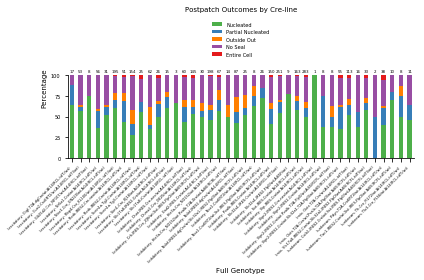

In [484]:
pal = ['#4daf4a', '#377eb8', '#ff7f00', '#984ea3', '#e41a1c']
ax1 = postpatch_percent.plot(kind = 'bar', stacked = True, color = pal)

axes = plt.gca()
axes.set_ylim(0,170)
plt.yticks([0,25,50,75,100], size = '5')
plt.xticks(size=3.5, rotation=45, ha='right')
#plt.legend(loc='upper right', prop={'size':5})
plt.xlabel('Full Genotype', fontsize='7')
plt.ylabel('Percentage', fontsize='7')

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_bounds(0, 100)
ax1.xaxis.set_ticks_position('bottom')
ax1.yaxis.set_ticks_position('left')
barWidth = 1

plt.title('Postpatch Outcomes by Cre-line', fontsize='7')
ax1.legend(["Nucleated", "Partial Nucleated", "Outside Out", "No Seal", "Entire Cell"], loc='upper center', frameon=False, fontsize='5', )

rects = ax1.patches
labels = postpatch_totals

for rect, label in zip (rects, labels):
    height = 103
    x_value = rect.get_x() + rect.get_width() / 2
    ax1.text(rect.get_x() + rect.get_width()/2, height, label, ha='center', va='bottom', size=4)
    
plt.tight_layout()
#fig_path = home/"documents"/"stash"/"ps-metadata-analysis"/"figures"/"patch_seq_log_mouse.csv"
plt.savefig('c:/users/rustym/documents/stash/ps-metadata-analysis/figures/postpatch_by_creline2', dpi=300)